<a href="https://colab.research.google.com/github/john-hafner/PHY451-Muon/blob/main/Decay_Counts_Rate_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decay Count Rate Analysis
Pull up one or more files, and calculate the count rate both of detected decays, and candidate muons that did not get a 2nd signal.  We'll want to use that to get some idea of what the background is, and where is the best voltage threshold to block it out.

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
# Gets to base of your google drive, don't change this.
base = 'drive/My Drive'
# Specific folder the data is stored in, may be multiple levels in, separated
# by forward slashes (/)
folder = 'PHY451 - Muons/Our Data'
# file name
file = 'muon_3-14-23.data'

# Combine the above locations to the full file path.
file_path = base + '/' + folder + '/' + file
df = pd.read_csv(file_path, delim_whitespace=True, names=['decay_time', 'timestamp'], header=None)
#df = pd.read_csv(base + '/' + folder + '/' + file, delim_whitespace=True, names=['decay_time', 'timestamp'], header=None)
#df = pd.read_csv('drive/My Drive/PHY451 - Muons/Our Data/muon_3-14-23.data', delim_whitespace=True, names=['decay_time', 'timestamp'], header=None)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
print(f'Loaded {df.shape[0]} records')
print('Records of T < 20000:', df[df['decay_time'] < 20000].shape[0])
print('Records of 20000 < T < 40000:', df[(df['decay_time'] >= 20000) & (df['decay_time'] < 40000)].shape[0])
print('Records of T >= 40000:', df[df['decay_time'] >= 40000].shape[0])
df.head(5)

Loaded 8321311 records
Records of T < 20000: 17874
Records of 20000 < T < 40000: 7114368
Records of T >= 40000: 1189069


,decay_time,timestamp
0,40000,2023-02-28 16:47:15
1,40000,2023-02-28 16:47:16
2,40000,2023-02-28 16:47:17
3,40000,2023-02-28 16:47:18
4,40000,2023-02-28 16:47:19


In [117]:
decay_df = df[df['decay_time'] < 20000].reset_index()
decay_df.head()

,index,decay_time,timestamp
0,157,1200,2023-02-28 16:48:01
1,1052,560,2023-02-28 16:50:12
2,1091,1220,2023-02-28 16:50:18
3,1247,1400,2023-02-28 16:50:39
4,1670,1780,2023-02-28 16:51:41


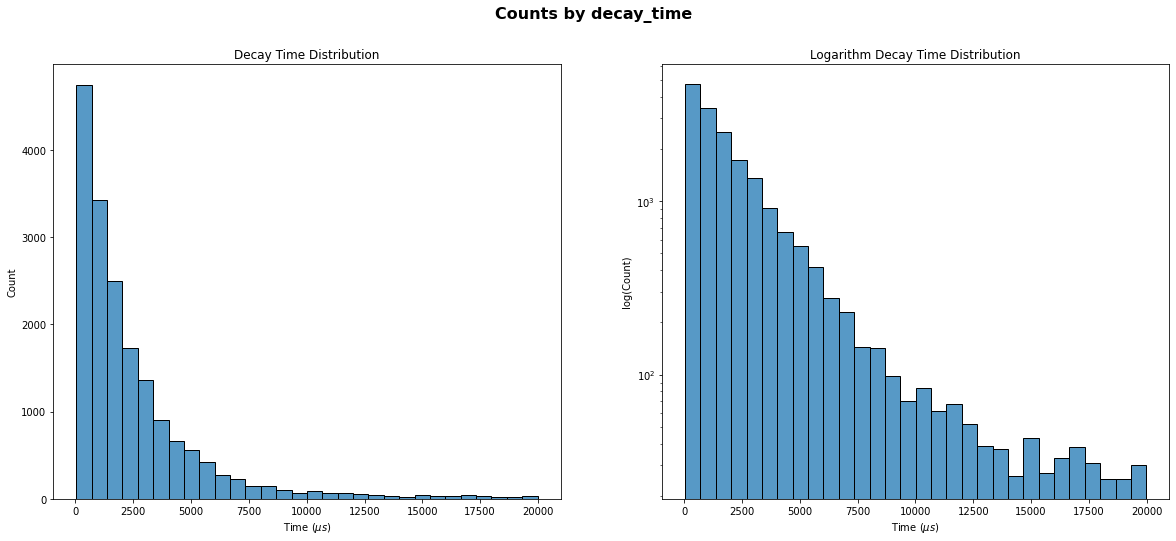

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))

fig.suptitle('Counts by decay_time', fontsize=16, fontweight='bold')
sns.histplot(data=decay_df['decay_time'], ax=ax[0], bins=30)
ax[0].set_title('Decay Time Distribution')
ax[0].set_xlabel('Time $(\mu s)$')
ax[0].set_ylabel('Count')

ax[1].set_title('Logarithm Decay Time Distribution')
ax[1].set_yscale('log')
ax[1].set_xlabel('Time $(\mu s)$')
ax[1].set_ylabel('log(Count)')
sns.histplot(data=decay_df['decay_time'], ax=ax[1], bins=30)
plt.show()

It looks like it flatlines past 15000, maybe 12500, especially on the logarithm scaled plot so an initial guess at background would be the counts in that range, getting the average and subtracting that from the rest of the bins.  But first we have to bin the data, which the above graph did automatically.  It's slightly more involved than I expected but not bad.  The cut function should be able to do it.

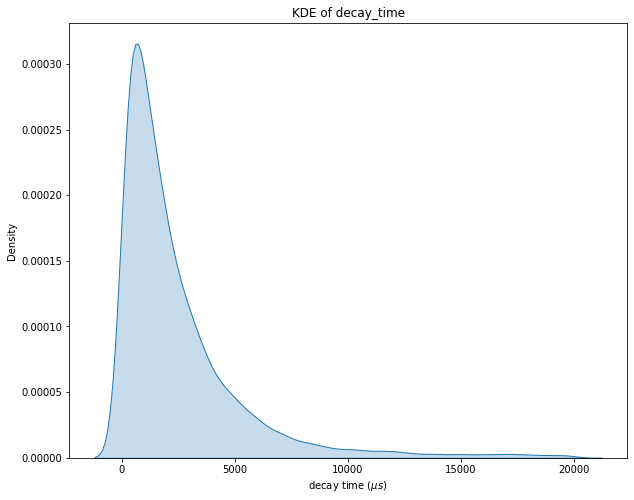

In [119]:
plt.figure(figsize=(10,8))
g = sns.kdeplot(data=decay_df['decay_time'], fill=True)

plt.title('KDE of decay_time')
plt.xlabel('decay time $(\mu s)$')
plt.show()

The decay time data shows the tell tale signs of being a Poisson distribution.  Which does make sense, this is basically a classic counting problem.  So it should (hopefully) obey Poisson statistics.

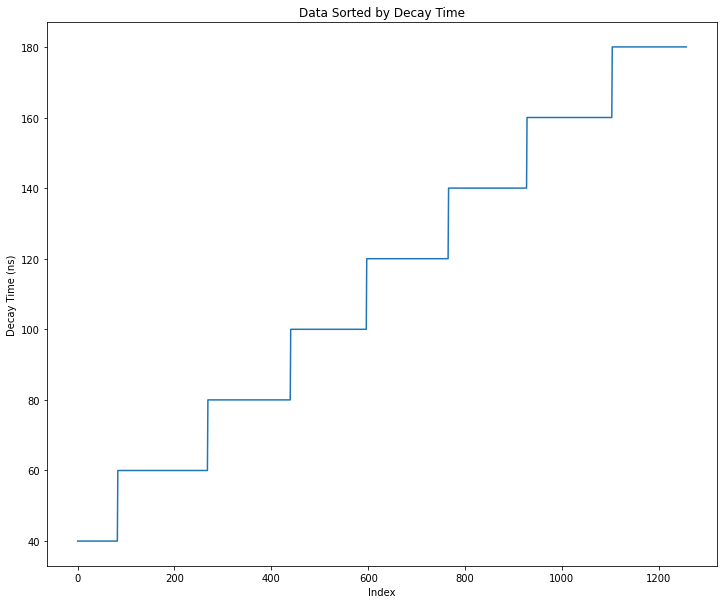

In [120]:
plt.figure(figsize=(12,10))
#plt.plot(df.sort_values('decay_time').reset_index()['decay_time'][:1200])
plt.plot(df[df['decay_time'] < 200].sort_values('decay_time').reset_index()['decay_time'])
plt.title('Data Sorted by Decay Time')
plt.xlabel('Index')
plt.ylabel('Decay Time (ns)')
plt.show()


This is the raw data sorted by its decay time value, at least for the values under 200 ns (0.2 $\mu s$).  It's a clear sawtooth pattern, indicating that the recorded values are not continuous but are being rounded.  It does look like the far left value at 40 ns is narrower than the other steps which the lab directions mentioned could be a problem.

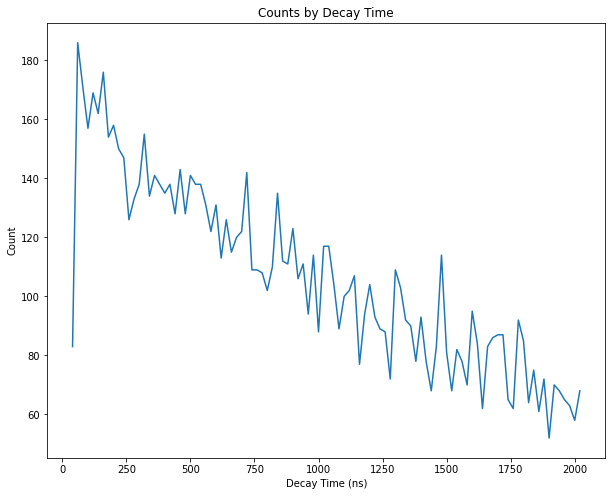

In [121]:
plt.figure(figsize=(10,8))
plt.title('Counts by Decay Time')
plt.plot(decay_df.groupby('decay_time').count().iloc[:100,0])
plt.xlabel('Decay Time (ns)')
plt.ylabel('Count')
plt.show()

Counting by the decay time values does show that the very first value (40 ns) has an anomalous drop.  So we'll probably want to not include it as we were warned about in the lab directions.  The rest seem OK, but we'll either just drop everything $\le 0.1\ \mu s$ or otherwise take care with setting up the bins when doing the stats.

In [122]:
decay_df = decay_df[decay_df['decay_time'] > 100]
decay_df.drop(columns=['index'], inplace=True)
decay_df.head()

<ipython-input-122-13e940c358e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decay_df.drop(columns=['index'], inplace=True)


,decay_time,timestamp
0,1200,2023-02-28 16:48:01
1,560,2023-02-28 16:50:12
2,1220,2023-02-28 16:50:18
3,1400,2023-02-28 16:50:39
4,1780,2023-02-28 16:51:41


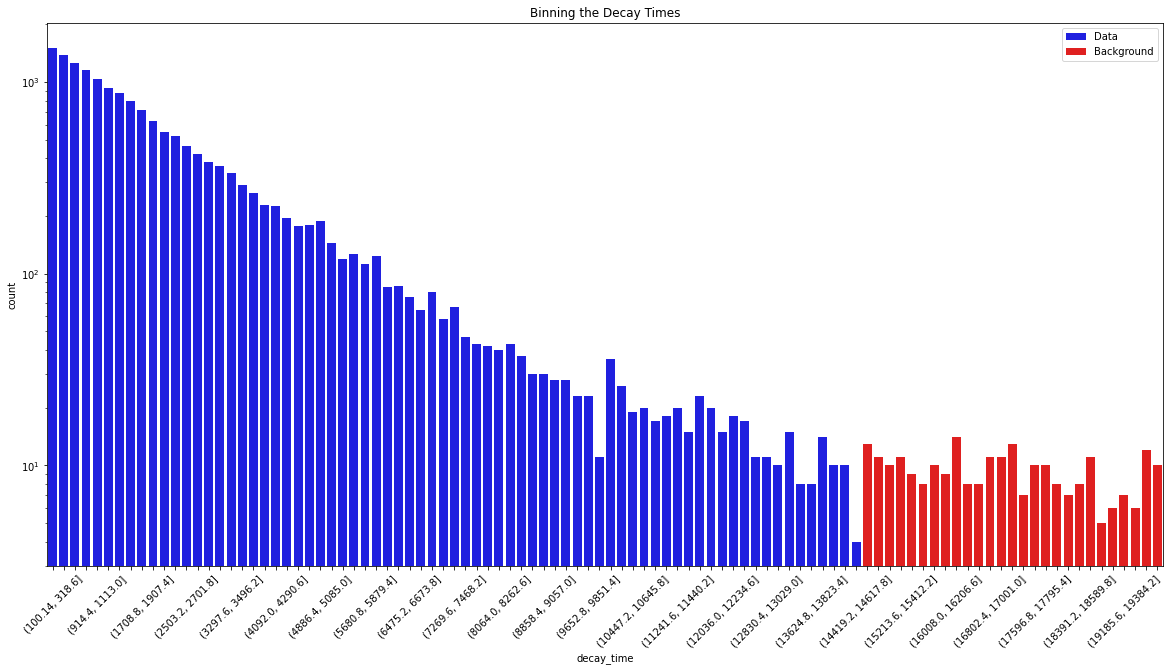

In [123]:
num_bins = 100
bg_split = 27
bin_df = pd.DataFrame({'count': decay_df['decay_time'].groupby(pd.cut(decay_df['decay_time'], num_bins)).count()})
plt.figure(figsize=(20,10))
g = sns.barplot(data=bin_df[:-bg_split], x=bin_df[:-bg_split].index, y='count', color='blue', label='Data')
g = sns.barplot(data=bin_df[-bg_split:], x=bin_df[-bg_split:].index, y='count', color='red', label='Background')
plt.yscale('log')
# rotate the bin labels
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# Show just every 4 bin labels to avoid clutter
n=4
ax = plt.gca()
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

plt.title('Binning the Decay Times')
plt.legend()
plt.show()

Above shows the data binned & I've just "eyeballed" what I think is a split between the good data (blue) and what is likely the background noise (red) and we'll average out that background value and subtract it from the rest of the data before doing a fit.

In [159]:
# Get the mean & stdev from the probable background.
# I don't think I'll use the stdev but might as well get it.
mean = bin_df[-bg_split:].mean()
std = bin_df[-bg_split:].std()

# Take the mean of the background away
mu_df = bin_df[:-bg_split] - mean

# Setting any that were less than 0 to 0.
mu_df.loc[mu_df['count'] < 0, 'count'] = 0

,count
decay_time,
"(100.14, 318.6]",1503.62963
"(318.6, 517.2]",1371.62963
"(517.2, 715.8]",1246.62963
"(715.8, 914.4]",1151.62963
"(914.4, 1113.0]",1030.62963


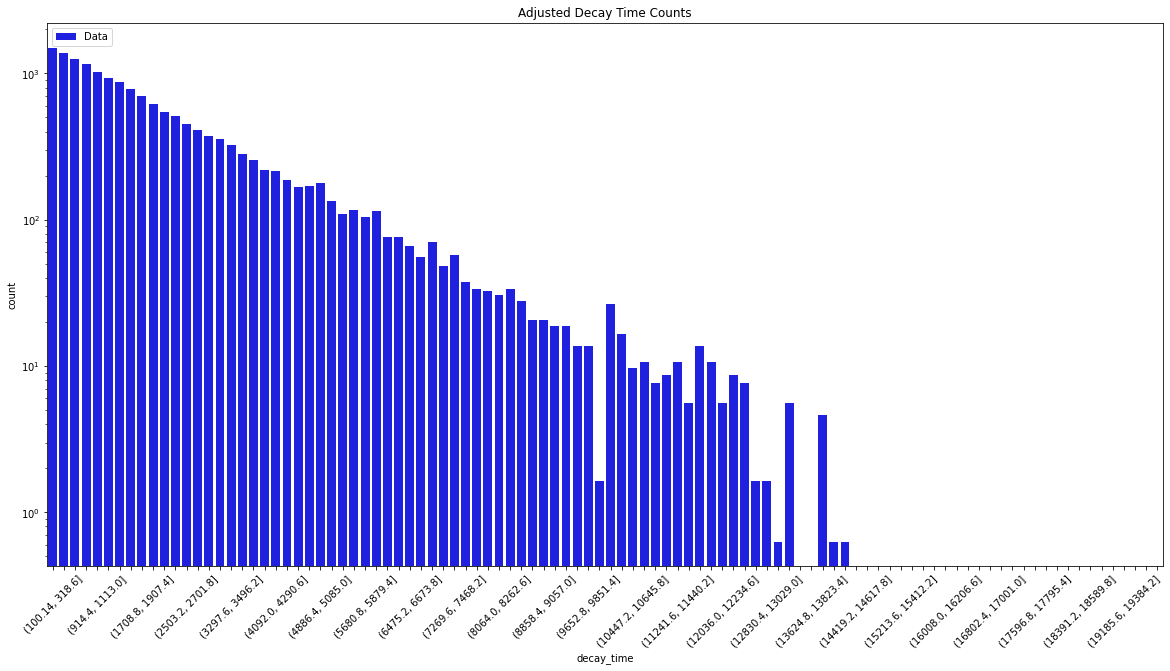

In [170]:
plt.figure(figsize=(20,10))
g = sns.barplot(data=mu_df, x=mu_df.index, y='count', color='blue', label='Data')
plt.yscale('log')
# rotate the bin labels
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# Show just every 4 bin labels to avoid clutter
n=4
ax = plt.gca()
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

plt.title('Adjusted Decay Time Counts')
plt.legend()
plt.show()

There should be a linear relationship
$$N(t) = N_0 e^{-\lambda t}$$
$$log(N) = log(N_0) - \lambda t$$

In [210]:
from sklearn.linear_model import LinearRegression

# Get the midpoint of each index interval and set it as x.
mu_df['x'] = [x.mid for x in mu_df.index]
mu_df['y'] = np.log10(mu_df['count'])
mu_df.head()



/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,count,x,y
decay_time,,,
"(100.14, 318.6]",1503.62963,209.37,3.177141
"(318.6, 517.2]",1371.62963,417.90,3.137237
"(517.2, 715.8]",1246.62963,616.50,3.095737
"(715.8, 914.4]",1151.62963,815.10,3.061313
"(914.4, 1113.0]",1030.62963,1013.70,3.013103


In [217]:
mu_df.loc[mu_df['y'] == -np.inf,'y'] = -0.200915 # the min value I saw
mu_df[-18:]

,count,x,y
decay_time,,,
"(11043.0, 11241.6]",8.62963,11142.3,0.935992
"(11241.6, 11440.2]",10.62963,11340.9,1.026518
"(11440.2, 11638.8]",5.62963,11539.5,0.750480
"(11638.8, 11837.4]",13.62963,11738.1,1.134484
"(11837.4, 12036.0]",10.62963,11936.7,1.026518
"(12036.0, 12234.6]",5.62963,12135.3,0.750480
"(12234.6, 12433.2]",8.62963,12333.9,0.935992
"(12433.2, 12631.8]",7.62963,12532.5,0.882503
"(12631.8, 12830.4]",1.62963,12731.1,0.212089


In [218]:
X = np.array(mu_df['x']).reshape(-1,1)
Y = np.array(mu_df['y']).reshape(-1,1)

model = LinearRegression()
model.fit(X, Y)

print(f'm-slope: {model.coef_}')
print(f'b-intercept: {model.intercept_}')

y_hat = model.predict(X)

m-slope: [[-0.00021965]]
b-intercept: [3.26318824]


In [254]:
#plt.plot(x[:73], y_hat, 'r--')
mu_df.loc[:,'y_hat'] = y_hat
mu_df.head()

,count,x,y,y_hat
decay_time,,,,
"(100.14, 318.6]",1503.62963,209.37,3.177141,3.217200
"(318.6, 517.2]",1371.62963,417.90,3.137237,3.171396
"(517.2, 715.8]",1246.62963,616.50,3.095737,3.127774
"(715.8, 914.4]",1151.62963,815.10,3.061313,3.084151
"(914.4, 1113.0]",1030.62963,1013.70,3.013103,3.040529


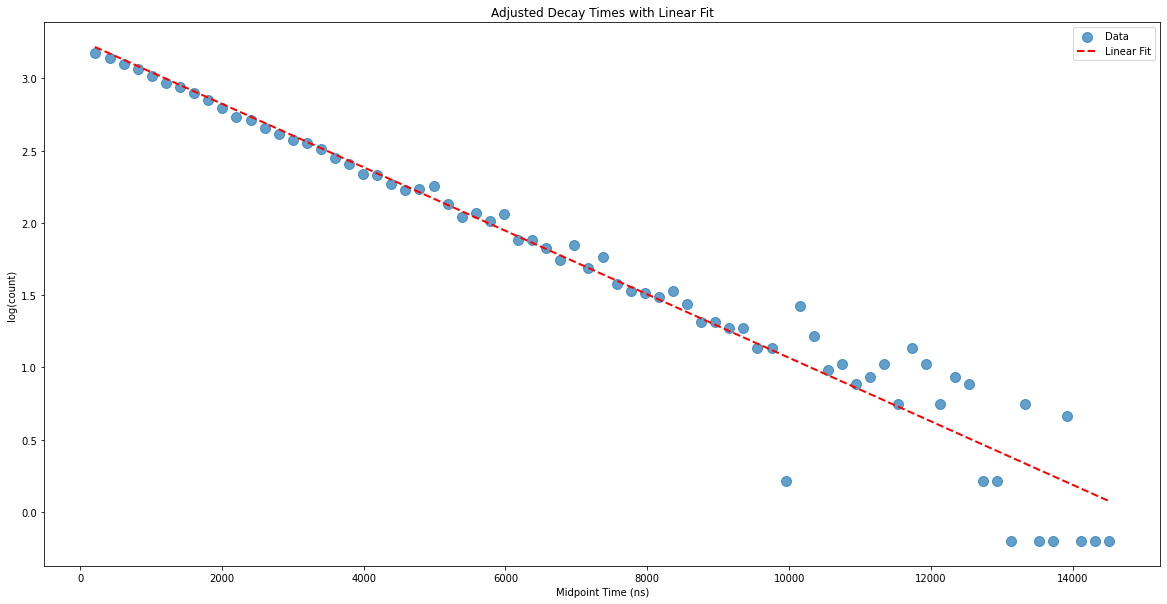

In [268]:
plt.figure(figsize=(20,10))
#g = sns.barplot(data=mu_df, x='x', y='y', color='blue', label='Data')

plt.scatter(mu_df['x'], mu_df['y'], label='Data', s=100, alpha=0.7)

plt.plot(mu_df['x'], mu_df['y_hat'], 'r--', linewidth=2, label='Linear Fit')

plt.title('Adjusted Decay Times with Linear Fit')
plt.ylabel('log(count)')
plt.xlabel('Midpoint Time (ns)')
plt.legend()
plt.show()

In [273]:
from sklearn.metrics import r2_score

print(f"R2: {r2_score(mu_df['y'], mu_df['y_hat']):.3f}")

R2: 0.948


In [278]:
T = 1/-float(model.coef_)
print(f'T: {T:.1f} ns')

T: 4552.7 ns


Assuming that the linear coefficient (slope) is $\lambda$, then the average life time $\tau$ should be $\frac{1}{\lambda}$.  I get about $4.55\ \mu s$, roughly double what it should be.

Not a bad $R^2$ score at all, but I still have to do $\chi^2$, and there's the fact that there's actual two signals in this data from the positive, and negative muons with slightly different lifetimes.  And we'll need a guess at the ratio between them.  The far right here shows signs of breaking away from the fit, that could either be due to the two curves causing more interference, or just due to the background still being present.

This is just a rough draft first stab.

# Data Analysis & Visualization
Just some additional exploratory analysis & descriptive statistics on the data to help me get familiar with it.

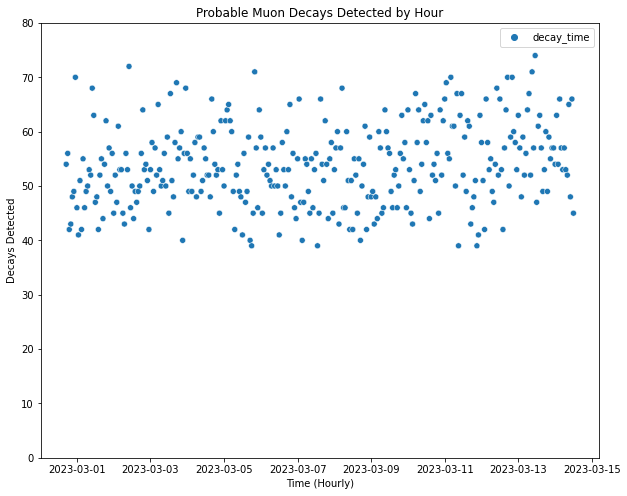

In [124]:
plt.figure(figsize=(10,8))
plt.xlabel('Time (Hourly)')
plt.ylabel('Decays Detected')
ax = plt.gca()
ax.set_ylim([0, 80])
sns.scatterplot(df[df['decay_time'] < 20000].set_index('timestamp').resample('H').count()[1:-1])
plt.title('Probable Muon Decays Detected by Hour')
plt.show()

It seems pretty consistent that we detect between 40 and 70 decays per hour.

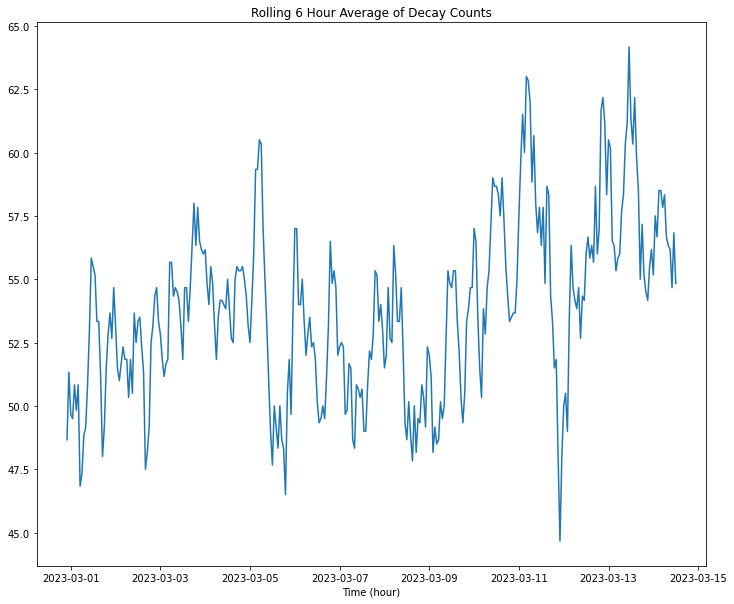

In [125]:
plt.figure(figsize=(12,10))
plt.plot(df[df['decay_time'] < 20000].set_index('timestamp').resample('H').count()[1:-1].rolling(window=6).mean())
plt.xlabel('Time (hour)')
plt.title('Rolling 6 Hour Average of Decay Counts')
plt.show()

This doesn't add anything extra, but it does include a rolling average if I want to copy/paste that for use elsewhere.  I think the scatterplot from earlier is a better example.

In [126]:
# Group the decays by hour of the day, so all of the noon values are now lumped together for example.
hourly_df = df[df['decay_time'] < 20000].set_index('timestamp').resample('H').count()[1:-1]
hourly_df.head(5)

,decay_time
timestamp,
2023-02-28 17:00:00,54
2023-02-28 18:00:00,56
2023-02-28 19:00:00,42
2023-02-28 20:00:00,43
2023-02-28 21:00:00,48


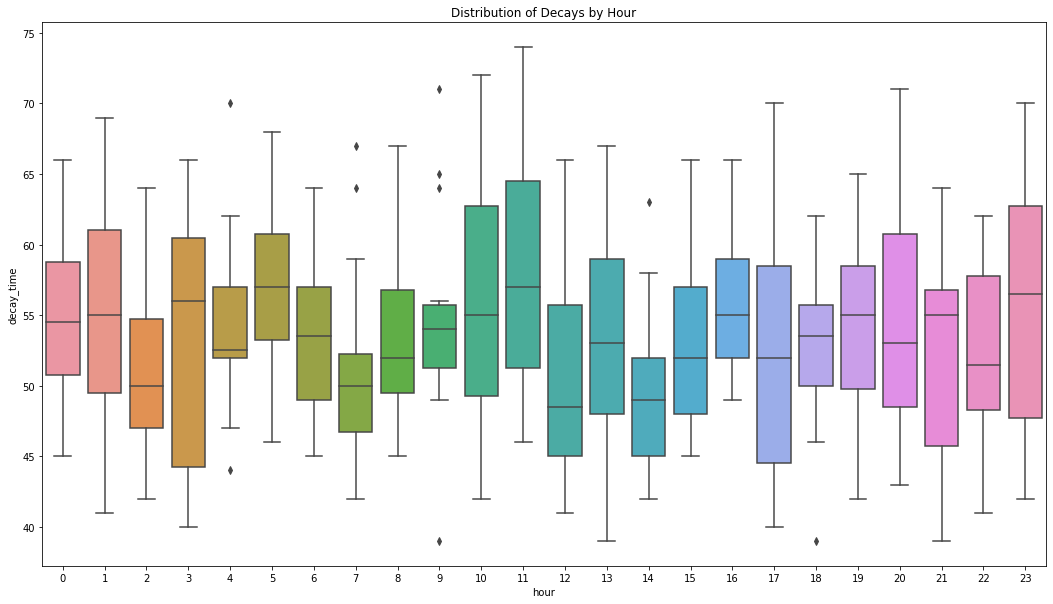

In [127]:
#hourly_df.groupby(hourly_df.index.hour).describe()
hourly_df['hour'] = hourly_df.index.hour
plt.figure(figsize=(18,10))
plt.title('Distribution of Decays by Hour')
sns.boxplot(data=hourly_df, x='hour', y='decay_time')
plt.show()

The data seems reasonably random and consistent.

In [129]:
hourly_20k = df[df['decay_time']==20000].set_index('timestamp').resample('H').count()[1:-1]
hourly_40k = df[df['decay_time']>20000].set_index('timestamp').resample('H').count()[1:-1]

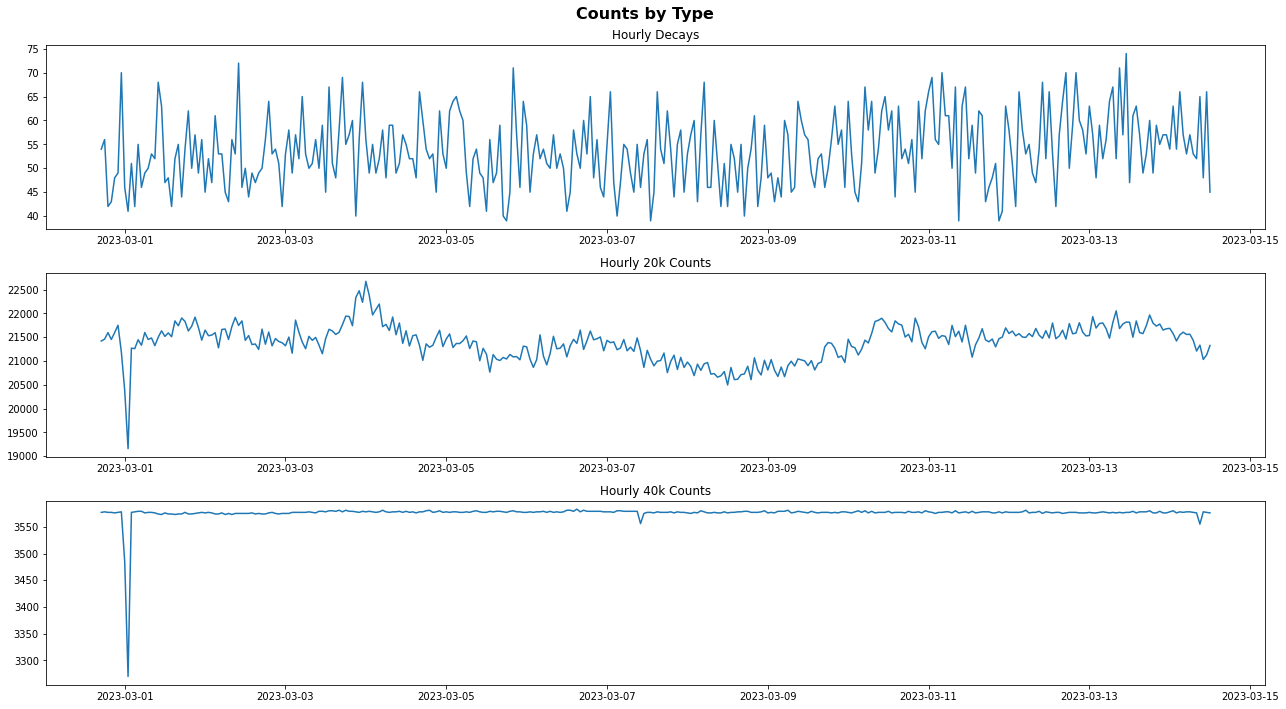

In [130]:
fig, ax = plt.subplots(3, 1, figsize=(18,10))
ax[0].plot(hourly_df.drop('hour', axis=1))
ax[0].set_title('Hourly Decays')
ax[1].plot(hourly_20k)
ax[1].set_title('Hourly 20k Counts')
ax[2].plot(hourly_40k)
ax[2].set_title('Hourly 40k Counts')
fig.suptitle('Counts by Type', fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()

The counts of decays (top), the 20k events that are single incident muons (middle), and the 40k events that are repeated clockcycles without another incident.  I have to re-review that section of the reading again to really firm up my understanding of the file format a little more.

# Muon Counts by Voltage
We'll try adjusting the high voltage on the detector, and the discriminator voltage independently and see what impact this has on the counts for the detector.

In [131]:
df_1 = pd.read_csv('drive/My Drive/PHY451 - Muons/Our Data/muon_1150HV_278D.data', delim_whitespace=True, names=['decay_time', 'timestamp'], header=None)
df_1['timestamp'] = pd.to_datetime(df_1['timestamp'], unit='s')
df_1 = df_1[df_1['decay_time'] == 20000].set_index('timestamp').resample('min').count()[1:-1]
df_1.loc[:, 'HV'] = 1150

df_2 = pd.read_csv('drive/My Drive/PHY451 - Muons/Our Data/muon_1201HV_278D.data', delim_whitespace=True, names=['decay_time', 'timestamp'], header=None)
df_2['timestamp'] = pd.to_datetime(df_2['timestamp'], unit='s')
df_2 = df_2[df_2['decay_time'] == 20000].set_index('timestamp').resample('min').count()[1:-1]
df_2.loc[:, 'HV'] = 1200

df_3 = pd.read_csv('drive/My Drive/PHY451 - Muons/Our Data/muon_1241HV_278D.data', delim_whitespace=True, names=['decay_time', 'timestamp'], header=None)
df_3['timestamp'] = pd.to_datetime(df_3['timestamp'], unit='s')
df_3 = df_3[df_3['decay_time'] == 20000].set_index('timestamp').resample('min').count()[1:-1]
df_3.loc[:, 'HV'] = 1242

df_tot = pd.concat((df_1, df_2, df_3), axis=0)

,decay_time,timestamp
0,40000,2023-03-14 22:33:11
1,40000,2023-03-14 22:33:12
2,20000,2023-03-14 22:33:12
3,20000,2023-03-14 22:33:12
4,20000,2023-03-14 22:33:12


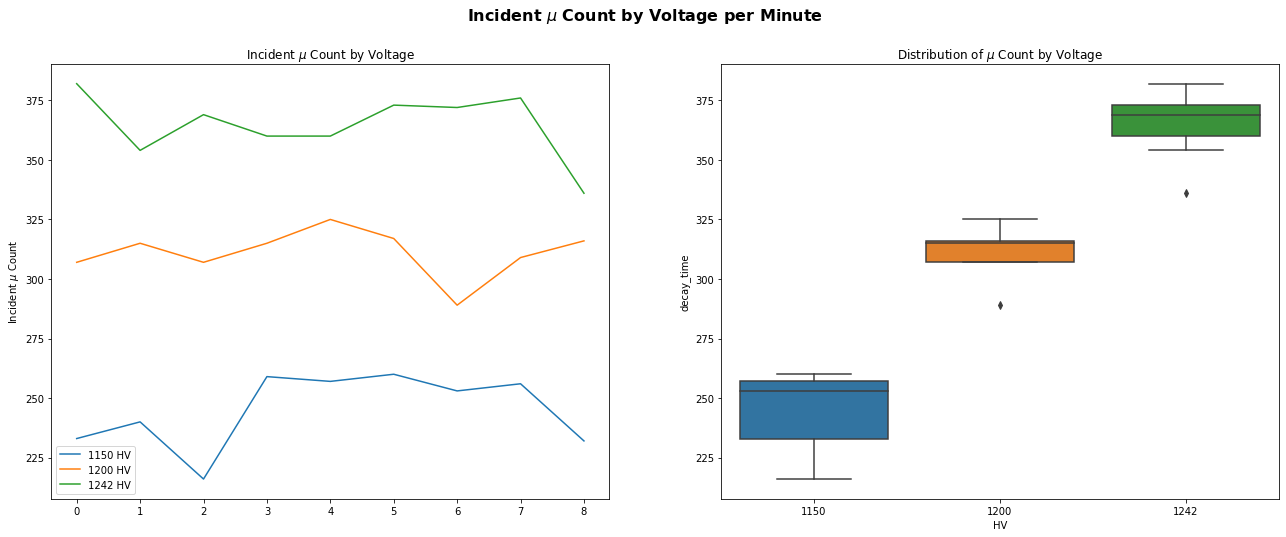

In [146]:
fig, ax = plt.subplots(1, 2, figsize=(22,8))

ax[0].plot(df_1.reset_index()['decay_time'], label='1150 HV')
ax[0].plot(df_2.reset_index()['decay_time'], label='1200 HV')
ax[0].plot(df_3.reset_index()['decay_time'], label='1242 HV')
ax[0].set_ylabel('Incident $\mu$ Count')
ax[0].set_title('Incident $\mu$ Count by Voltage')
ax[0].legend()

ax[1].set_title('Distribution of $\mu$ Count by Voltage')
ax[1].set_xlabel('Voltage')
ax[1].set_ylabel('Incident $\mu$ Count')
sns.boxplot(data=df_tot, x='HV', y='decay_time', ax=ax[1])

fig.suptitle('Incident $\mu$ Count by Voltage per Minute', fontsize=16, fontweight='bold')
plt.show()

Grouping the muon data we took for different voltage settings clearly shows that as voltage increases the incident muon count increases.  The discriminator was set to 5 I believe, or 7 I'll have to double check my notes.  But this might be bad, we've been leaving it cranked up to "10" on the voltage for the detector, which corresponds to the high voltage of 1242 V.  Maybe we're throwing off our counts by doing that.  We'd have to see how, if it all, it impacts the range of timings we get for the < 20k events.